#Week 5 Kaggle Assignment

**Problem Description**

With the rapid advancedment of computer vision, generative adversarial networks (GANs) has helped to generate very realistic images.

For this challenge, we will attempt to generate images in the style of Monet, and see how good and realistic the images are.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images, which for this case will be in Monet style.  This generator is trained using a discriminator.

The generator will try to trick the discriminator into thinking it is a real image, while the discriminator tries to accurately classify the real vs. generated images. The model will be evaluated based on MiFID (Memorization-informed Fréchet Inception Distance), which measures how good the generated images are. A lower MiFID score indicates that the pictures are better generated.


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io

**Exploring the dataset**

We have been provided with 300 Monet paintings sized 256x256 to train our model. As the TFRecord format is provided, I will use the TFRecord format for more efficient processing. We will have 7028 photos to generate in Monet style.

But first, I would need to examine what structure my TFRecord is using.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
monetpath = '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec'
monetfiles = tf.io.gfile.glob(str(monetpath + '/*.tfrec'))
print('Monet TFRecord Files:', len(monetfiles))

Monet TFRecord Files: 5


In [5]:
photopath = '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/photo_tfrec'
photofiles = tf.io.gfile.glob(str(photopath + '/*.tfrec'))
print('Non-Monet TFRecord Files:', len(photofiles))

Non-Monet TFRecord Files: 20


In [6]:
tfrpath = monetfiles[0]

monetrawdata = tf.data.TFRecordDataset(tfrpath)

for i in monetrawdata.take(1):
    sample = tf.train.Example()
    sample.ParseFromString(i.numpy())
    print(sample)

features {
  feature {
    key: "target"
    value {
      bytes_list {
        value: "monet"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\035\000\000\003\001\001\001\001\001\001\001\000\000\000\000\000\000\000\005\006\007\004\010\003\000\t\001\002\377\304\000D\020\000\001\003\002\004\003\005\005\006\004\005\003\003\005\000\000\003\004\005\023\000\006\007\024#3\001\025C\010$Scs\

We can see that there are three keys "target", "image" and "image name". The one we have to decode to read is the "image". We will also do some processing to normalize the image.

In [7]:
features = {
    'image': tf.io.FixedLenFeature([], tf.string)
}

def decode_image(p):

    decode_features = tf.io.parse_single_example(p, features)
    image = tf.io.decode_jpeg(decode_features['image'], channels=3)
    image = (tf.cast(image, tf.float32) / 127.5)- 1.0

    return image

We also need a function to load our dataset.

In [8]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024)
    return dataset

In [9]:
monet_data = load_dataset(monetfiles).batch(1)
photo_data = load_dataset(photofiles).batch(1)

Let's see how the images from the Monet files and the normal images look like.

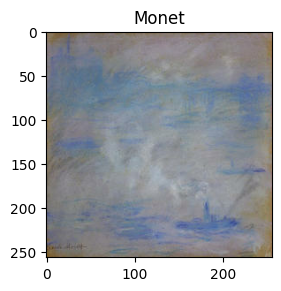

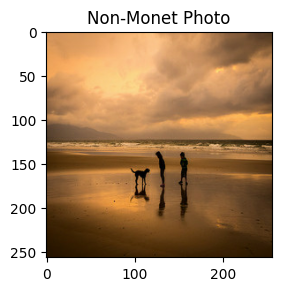

In [10]:
monetsample = next(iter(monet_data))
monetsample = monetsample[0]
photosample = next(iter(photo_data))
photosample = photosample[0]

plt.subplot(121)
plt.imshow(monetsample * 0.5 + 0.5)
plt.title("Monet")
plt.show()

plt.subplot(122)
plt.imshow(photosample* 0.5 + 0.5)
plt.title("Non-Monet Photo")
plt.show()

Now we can start building our generator and our discriminator. I'm using the CycleGAN tutorial here.

In [12]:
outputchannel = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    output = keras.Sequential()
    output.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        output.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    output.add(layers.LeakyReLU())

    return output

In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    output = keras.Sequential()
    output.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    output.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        output.add(layers.Dropout(0.5))

    output.add(layers.ReLU())

    return output

In [14]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    downstack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    upstack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4), #
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(outputchannel, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in downstack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(upstack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
monetgenerator = Generator()
photogenerator = Generator()

monetdiscriminator = Discriminator()
photodiscriminator = Discriminator()

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetgenerator,
        photogenerator,
        monetdiscriminator,
        photodiscriminator,
        lambdacycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetgenerator
        self.p_gen = photogenerator
        self.m_disc = monetdiscriminator
        self.p_disc = photodiscriminator
        self.lambdacycle = lambdacycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) + self.cycle_loss_fn(real_photo, cycled_photo)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Defining loss functions**

In [19]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [20]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
cyclegan_model = CycleGan(
        monetgenerator, photogenerator, monetdiscriminator, photodiscriminator
    )

cyclegan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
cyclegan_model.fit(
    tf.data.Dataset.zip((monet_data, photo_data)),
    epochs=20
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 173s 213ms/step - monet_disc_loss: 0.6405 - monet_gen_loss: 5.2436 - photo_disc_loss: 0.6244 - photo_gen_loss: 5.3507
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.6635 - monet_gen_loss: 3.6346 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.7671
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - monet_disc_loss: 0.6569 - monet_gen_loss: 3.5461 - photo_disc_loss: 0.6251 - photo_gen_loss: 3.6992
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - monet_disc_loss: 0.6460 - monet_gen_loss: 3.4327 - photo_disc_loss: 0.5744 - photo_gen_loss: 3.6793
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - monet_disc_loss: 0.6392 - monet_gen_loss: 3.3164 - photo_disc_loss: 0.5752 - photo_gen_loss: 3.5605
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 3.2427 - photo_disc_loss: 0.6093 - photo_gen_loss: 3.4021
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 3.2118 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.3040
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - monet_disc_l

Source:
[Kaggle tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Build-the-generator)

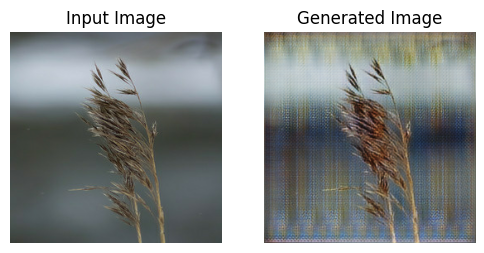

In [28]:
def generate_images(generator, input):
  generated = generator(input)
  plt.figure(figsize=(6, 6))
  display_list = [input[0], generated[0]]
  title = ['Input Image', 'Generated Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

sampleimage = next(iter(photo_data.skip(2)))
generate_images(monetgenerator, sampleimage)

In [29]:
output_dir = "/content/drive/MyDrive/Jiayi_master_5511/output"
os.makedirs(output_dir, exist_ok=True)

for i, batch in enumerate(photo_data):
    pred = monetgenerator(batch, training=False)
    pred = pred[0].numpy()
    pred = (pred + 1) / 2.0
    pred = (pred * 255).astype(np.uint8)
    filename = os.path.join(output_dir, f"pred_{i:04d}.png")
    Image.fromarray(pred).save(filename)
    print(f"Saved {filename}")

Streaming output truncated to the last 5000 lines.
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2038.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2039.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2040.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2041.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2042.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2043.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2044.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2045.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2046.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2047.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2048.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2049.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2050.png
Saved /content/drive/MyDrive/Jiayi_master_5511/output/pred_2051.p